In [1]:
import os
import argparse
import numpy as np
import pandas as pd

import torch
from torch_geometric.utils import remove_self_loops, scatter


def node_homophily(edge_index, y):
    # taken from https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/utils/_homophily.py
    row, col = edge_index
    out = torch.zeros(row.size(0), device=row.device)
    out[y[row] == y[col]] = 1.
    out = scatter(out, col, 0, dim_size=y.size(0), reduce='mean')
    return out

def calculate_homophily_ratio(data_list):
    # assuming the first node is the center node
    ratio_list = []
    for data in data_list:
        edge_index, y = data.edge_index, data.node_labels.squeeze(-1)
        edge_index, _ = remove_self_loops(edge_index)
        if edge_index.shape[1] > 0:
            ratios = node_homophily(edge_index, y)
            ratio_list.append(ratios[0].item())
        else:
            ratio_list.append(0)

    return ratio_list

def calculate_accuracy(data_list):
    acc_list = []
    for data in data_list:
        y_pred, y_true = data.y_pred, data.y
        acc_list.append((y_pred == y_true).item())

    return acc_list

def calculate_sd(data_list, thres=[0, 0.2, 0.4, 0.6, 0.8, 1]):
    ratio = np.array(calculate_homophily_ratio(data_list))
    acc = np.array(calculate_accuracy(data_list))

    group_acc = []
    for i in range(len(thres) - 1):
        lower, upper = thres[i], thres[i + 1]
        if i == 0 or i == len(thres) - 2:
            flags = np.logical_and(ratio >= lower, ratio <= upper)
        elif i == 1 or i == len(thres) - 3:
            flags = np.logical_and(ratio > lower, ratio < upper)
        else:
            flags = np.logical_and(ratio >= lower, ratio < upper)
        
        group_acc.append(acc[flags].mean())
    
    sd = np.std(group_acc)
    cv = sd / acc.mean()

    return group_acc, sd, cv


THRES_DICT = {
    'cora': [0, 0.333, 0.5, 0.75, 1, 1],
    'citeseer': [0, 0, 0.5, 0.667, 1, 1],
    'pubmed': [0, 0, 0.5, 0.8, 1, 1],
}


/tmp/ipykernel_2852845/895572735.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [38]:
import matplotlib
import matplotlib.pyplot as plt

def main(data_name='cora', binary=True, quantile=False, num_groups=5, groups_to_keep=None):
    files = os.listdir('../results/predictions')
    files = [x for x in files if data_name in x and x.endswith('.pt')]    
    
    ori_files = [x for x in files if 'augFalse' in x]
    aug_files = [x for x in files if 'augTrue' in x]

    if groups_to_keep is not None:
        prefixes = [ori_files[0].split('-r.')[0]] + groups_to_keep
    else:
        prefixes = np.unique([x.split('-r.')[0] for x in files])
    
    if binary:
        thres = [0, 0.5, 1]
    
    else:
        if quantile:
            fname = [x for x in ori_files if 'r.0' in x][0]
            data_list = torch.load(f'../results/predictions/{fname}')
            ratio = np.array(calculate_homophily_ratio(data_list))
        
            # determine thresholds
            grid = np.arange(100) / 100
            ratio_quantiles = np.quantile(ratio, q=grid)
        
            upper = grid[np.where(ratio_quantiles == 1)[0][0]]
            lower = grid[np.where(ratio_quantiles == 0)[0][-1]]
        
            if (1 - upper) / (num_groups - 1) >= lower + 0.01:
                qs = np.linspace(0, upper, num_groups)
                thres = np.quantile(ratio, q=qs).tolist() + [1]
            else:
                qs = np.linspace(lower, upper, num_groups - 1)
                thres = [0] + np.quantile(ratio, q=qs).tolist() + [1]
        
        else:
            thres = THRES_DICT[data_name]
    
    print(f'thres: {thres}')
    
    acc_df_list = []
    labels = []
    for p in prefixes:
        target_files = [x for x in files if x.startswith(p)]
    
        group_acc_list = []
        sd_list = []
        cv_list = []
        for f in target_files:
            data_list = torch.load(f'../results/predictions/{f}')
            group_acc, sd, cv = calculate_sd(data_list, thres)
            group_acc_list.append(group_acc)
            sd_list.append(sd)
            cv_list.append(cv)
    
        print(f"Prefix: {p}")
        print(f'sd = {np.mean(sd_list):.4f} +/- {np.std(sd_list):.4f}')
        print(f'cv = {np.mean(cv_list):.4f} +/- {np.std(cv_list):.4f}')
    
        acc_df = pd.DataFrame(group_acc_list, index=range(len(group_acc_list)), columns=range(len(thres) - 1))
        acc_df_list.append(acc_df)
        labels.append(p)

    cmap = matplotlib.colormaps.get_cmap('tab20')
    colors = [cmap(i / len(acc_df_list)) for i in range(len(acc_df_list))]
    
    # Position of the groups on the x-axis
    x = np.arange(len(acc_df.columns))
    
    # Width of the bars
    width = 0.8 / len(acc_df_list)  # Adjust the width so bars fit within one group unit
    
    # Start a new figure
    plt.figure(figsize=(10, 6))
    
    # Plot each dataframe's bars
    for i, (df, label) in enumerate(zip(acc_df_list, labels)):
        # Calculate means and standard deviations
        means = df.mean()
        stds = df.std()
    
        # Plotting
        plt.bar(x + i * width, means, width, yerr=stds, label=label, capsize=5, color=colors[i])
    
    # Set x-ticks and x-tick labels
    plt.xticks(x + width * len(acc_df_list) / 2 - width / 2, acc_df_list[0].columns)
    
    # Adding labels and title
    plt.xlabel('Groups')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Accuracy across Homophily Ratio')
    plt.legend(title="Dataframes", loc='upper left', bbox_to_anchor=(1, 1))
    
    # Show the plot
    plt.show()

thres: [0, 0.5, 1]
Prefix: coef-100_graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replTrue
sd = 0.2238 +/- 0.0081
cv = 0.2781 +/- 0.0108
Prefix: coef-100_graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep32_replTrue
sd = 0.2160 +/- 0.0069
cv = 0.2685 +/- 0.0092
Prefix: coef-100_n_step-10_graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replTrue
sd = 0.2188 +/- 0.0083
cv = 0.2712 +/- 0.0115
Prefix: cora__augFalse
sd = 0.2189 +/- 0.0058
cv = 0.2724 +/- 0.0082
Prefix: graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep10_replTrue
sd = 0.2120 +/- 0.0056
cv = 0.2629 +/- 0.0075
Prefix: graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep128_replTrue
sd = 0.2173 +/- 0.0044
cv = 0.2722 +/- 0.0069
Prefix: graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replFalse
sd = 0.2113 +/- 0.0054
cv = 0.2623 +/- 0.0078
Prefix: graph_class_guide_cora__augTrue_full_nr_github

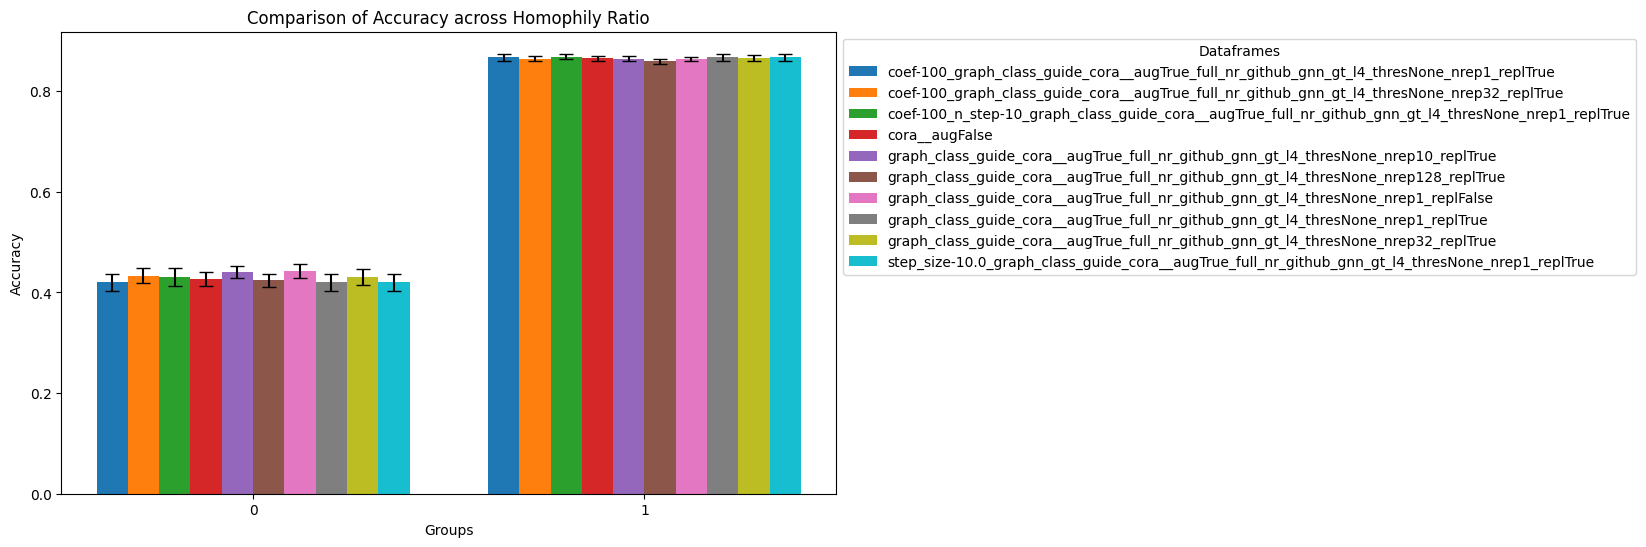

In [27]:
data_name = 'cora'
binary = True
quantile = False
num_groups = 5

main(data_name, binary, quantile, num_groups)

thres: [0, 0.5, 1]
Prefix: graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep10_replTrue
sd = 0.2120 +/- 0.0056
cv = 0.2629 +/- 0.0075
Prefix: graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replFalse
sd = 0.2113 +/- 0.0054
cv = 0.2623 +/- 0.0078
Prefix: cora__augFalse
sd = 0.2189 +/- 0.0058
cv = 0.2724 +/- 0.0082


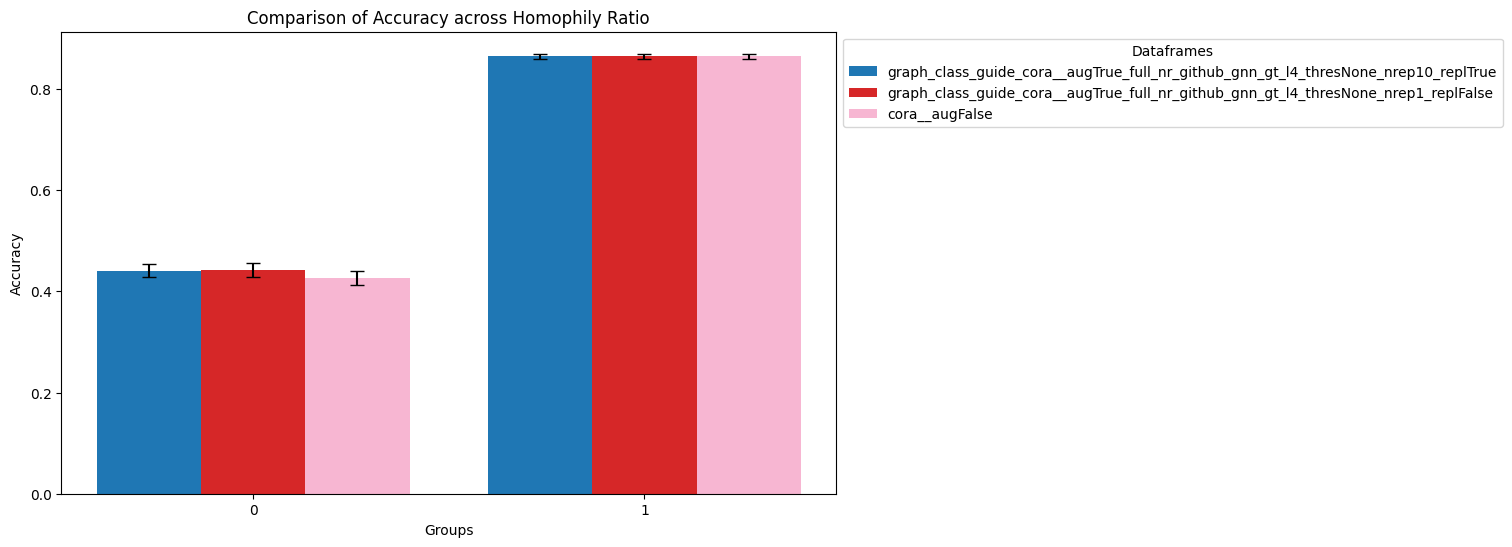

In [37]:
data_name = 'cora'
binary = True
quantile = False
num_groups = 5

groups_to_keep = [
    'graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep10_replTrue',
    'graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replFalse'
]
main(data_name, binary, quantile, num_groups, groups_to_keep)

thres: [0.0, 0.5, 1.0, 1]
Prefix: coef-100_graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replTrue
sd = 0.2181 +/- 0.0080
cv = 0.2709 +/- 0.0104
Prefix: coef-100_graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep32_replTrue
sd = 0.2101 +/- 0.0059
cv = 0.2612 +/- 0.0080
Prefix: coef-100_n_step-10_graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replTrue
sd = 0.2133 +/- 0.0087
cv = 0.2643 +/- 0.0118
Prefix: cora__augFalse
sd = 0.2129 +/- 0.0062
cv = 0.2650 +/- 0.0085
Prefix: graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep10_replTrue
sd = 0.2070 +/- 0.0056
cv = 0.2568 +/- 0.0077
Prefix: graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep128_replTrue
sd = 0.2101 +/- 0.0044
cv = 0.2631 +/- 0.0071
Prefix: graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replFalse
sd = 0.2057 +/- 0.0058
cv = 0.2554 +/- 0.0083
Prefix: graph_class_guide_cora__augTrue_full_nr

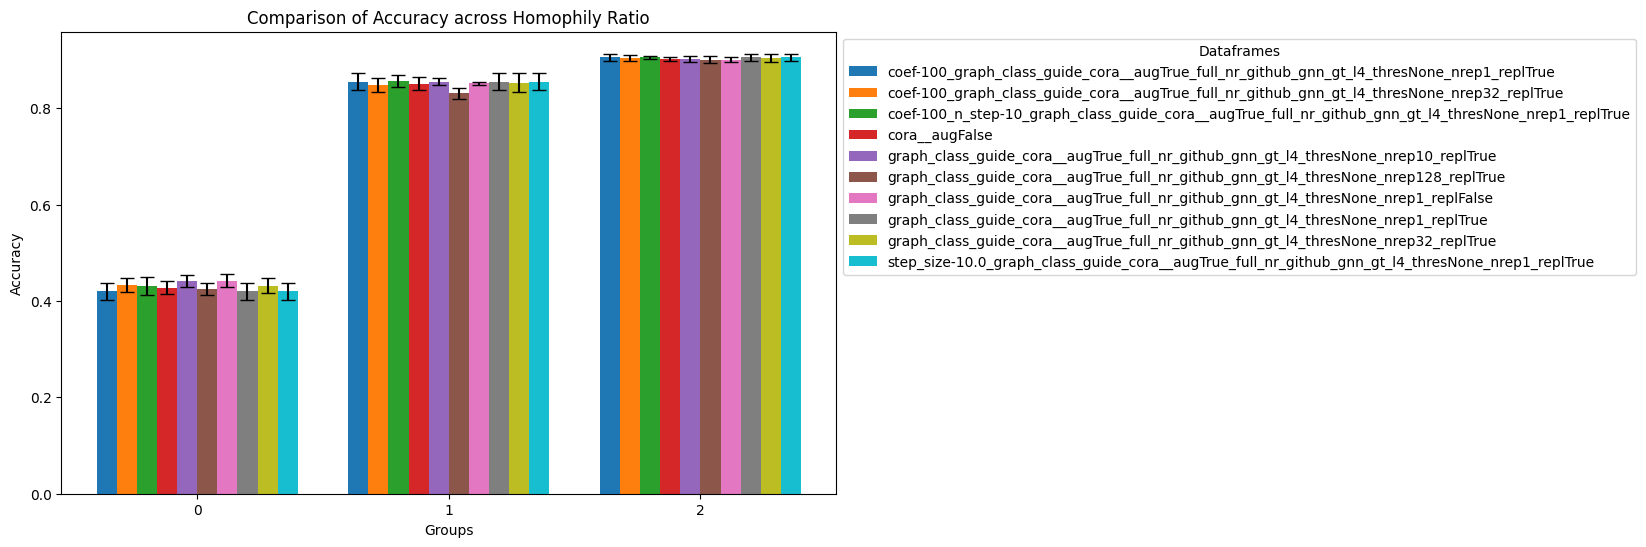

In [33]:
data_name = 'cora'
binary = False
quantile = True
num_groups = 3

main(data_name, binary, quantile, num_groups)

thres: [0.0, 0.25, 0.5, 0.6666666865348816, 0.75, 1.0, 1]
Prefix: cora__augFalse
sd = 0.2325 +/- 0.0097
cv = 0.2894 +/- 0.0128
Prefix: graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep10_replTrue
sd = 0.2232 +/- 0.0084
cv = 0.2769 +/- 0.0110


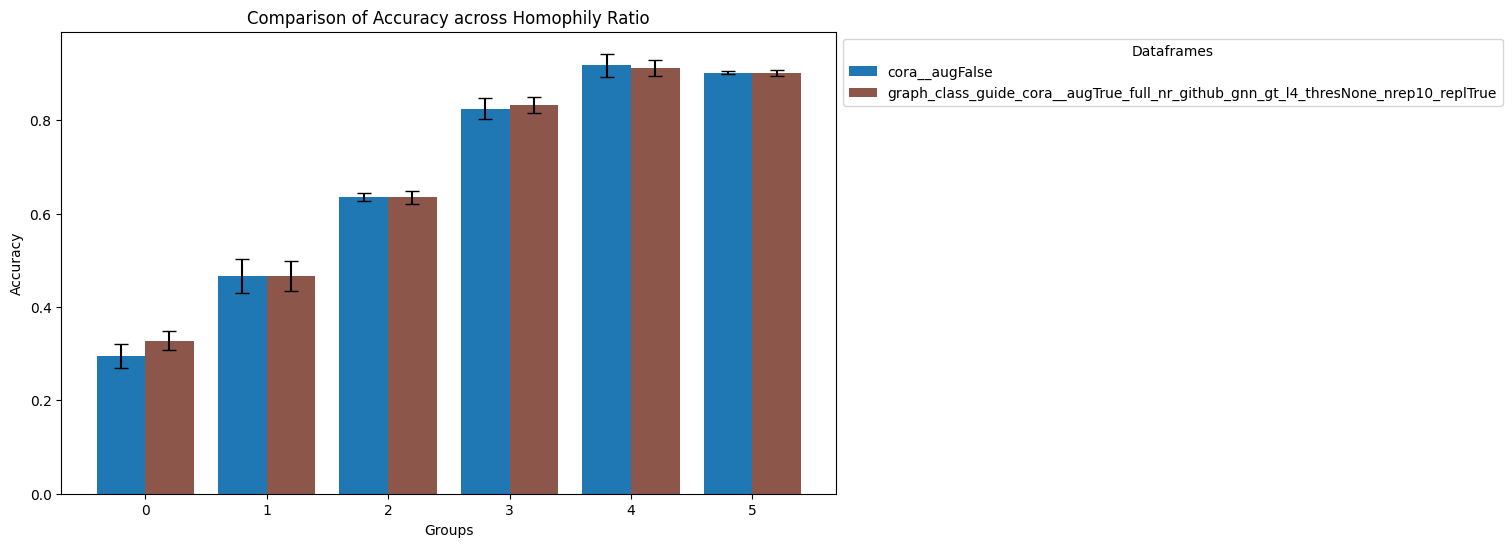

In [48]:
data_name = 'cora'
binary = False
quantile = True
num_groups = 6

groups_to_keep = [
    'graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep10_replTrue',
    # 'graph_class_guide_cora__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replFalse'
]
main(data_name, binary, quantile, num_groups, groups_to_keep)

thres: [0, 0.5, 1]
Prefix: citeseer__augFalse
sd = 0.2007 +/- 0.0040
cv = 0.2902 +/- 0.0064
Prefix: coef-100_graph_class_guide_citeseer__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep10_replTrue
sd = 0.1982 +/- 0.0049
cv = 0.2891 +/- 0.0065
Prefix: graph_class_guide_citeseer__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep10_replTrue
sd = 0.1984 +/- 0.0046
cv = 0.2892 +/- 0.0062
Prefix: graph_class_guide_citeseer__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep128_replTrue
sd = 0.1884 +/- 0.0041
cv = 0.2799 +/- 0.0059
Prefix: graph_class_guide_citeseer__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep16_replTrue
sd = 0.1985 +/- 0.0057
cv = 0.2902 +/- 0.0089


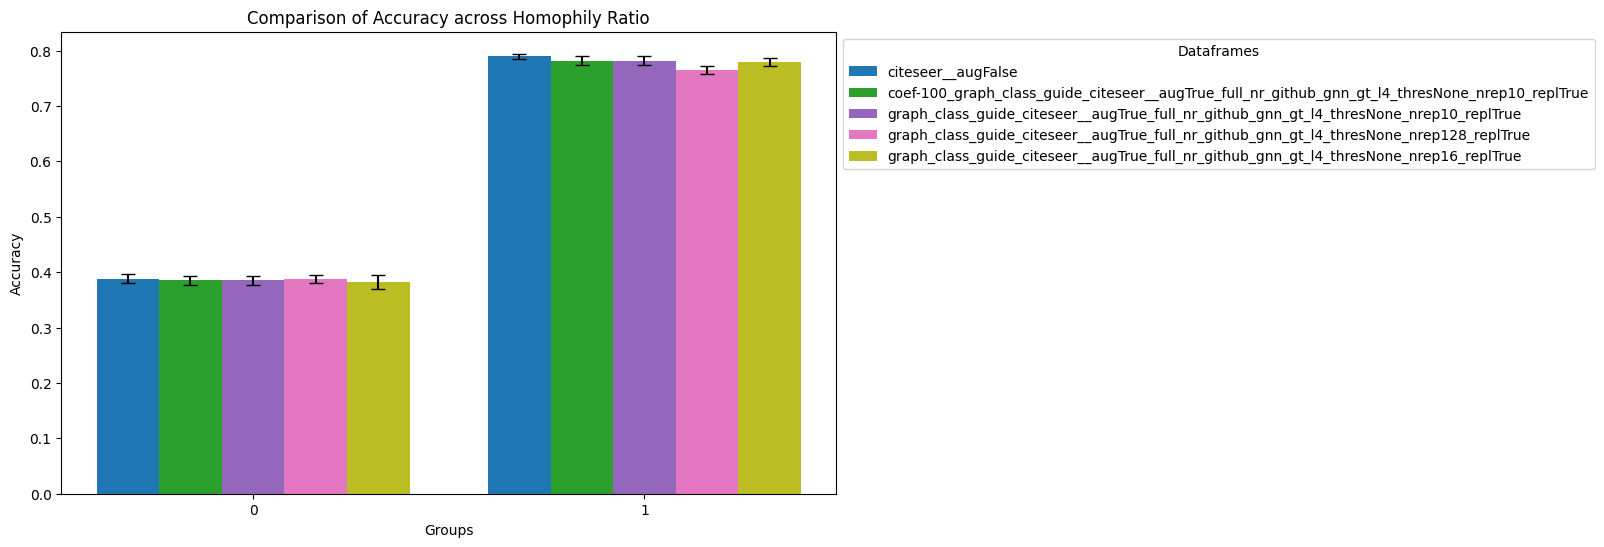

In [50]:
data_name = 'citeseer'
binary = True
quantile = False
num_groups = 5

main(data_name, binary, quantile, num_groups)

thres: [0, 0.5, 1]
Prefix: aug_val_aug_test_graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replTrue
sd = 0.1805 +/- 0.0048
cv = 0.2283 +/- 0.0060
Prefix: coef-100_graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replTrue
sd = 0.1795 +/- 0.0042
cv = 0.2270 +/- 0.0053
Prefix: coef-100_n_step-10_graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replTrue
sd = 0.1795 +/- 0.0042
cv = 0.2270 +/- 0.0053
Prefix: graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep10_replTrue
sd = 0.1784 +/- 0.0034
cv = 0.2261 +/- 0.0040
Prefix: graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep128_replTrue
sd = 0.1793 +/- 0.0013
cv = 0.2286 +/- 0.0017
Prefix: graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep16_replTrue
sd = 0.1785 +/- 0.0031
cv = 0.2259 +/- 0.0037
Prefix: graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep1_replFalse
sd = 0.1781

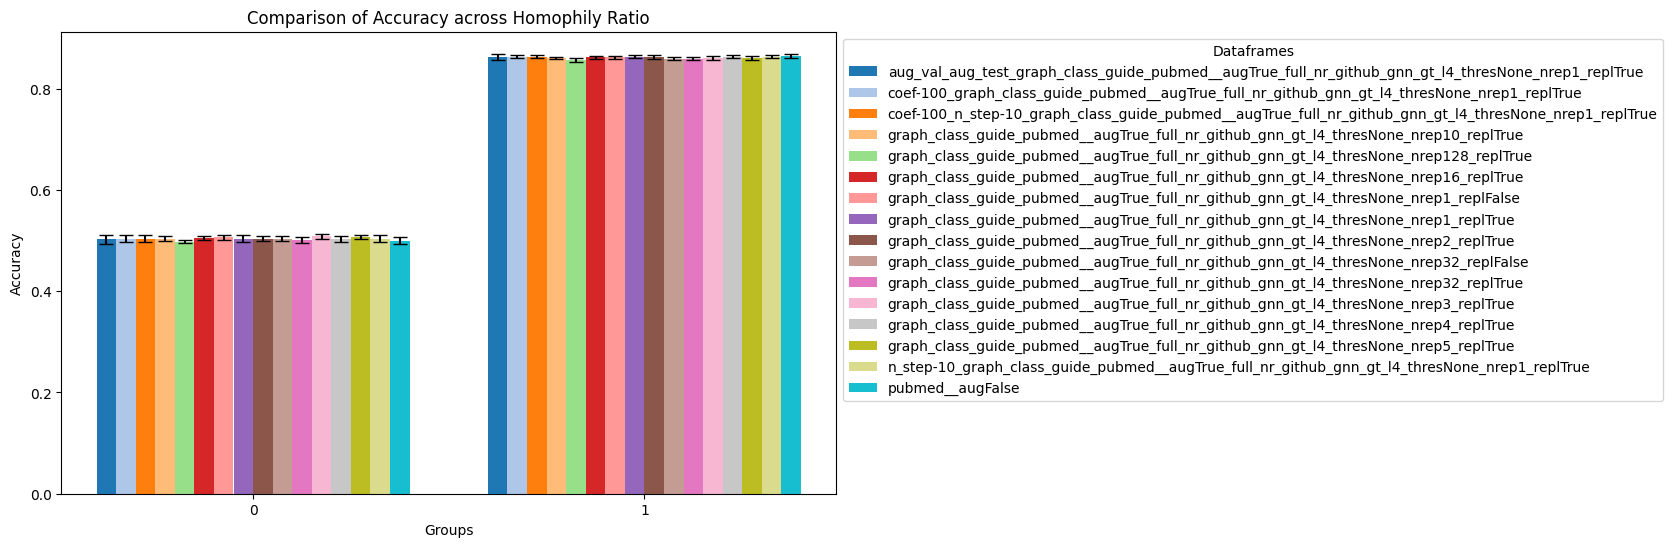

In [29]:
data_name = 'pubmed'
binary = True
quantile = False
num_groups = 5

main(data_name, binary, quantile, num_groups)

thres: [0, 0.5, 1]
Prefix: pubmed__augFalse
sd = 0.1825 +/- 0.0039
cv = 0.2304 +/- 0.0046
Prefix: graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep3_replTrue
sd = 0.1763 +/- 0.0032
cv = 0.2232 +/- 0.0039
Prefix: graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep5_replTrue
sd = 0.1774 +/- 0.0024
cv = 0.2245 +/- 0.0028


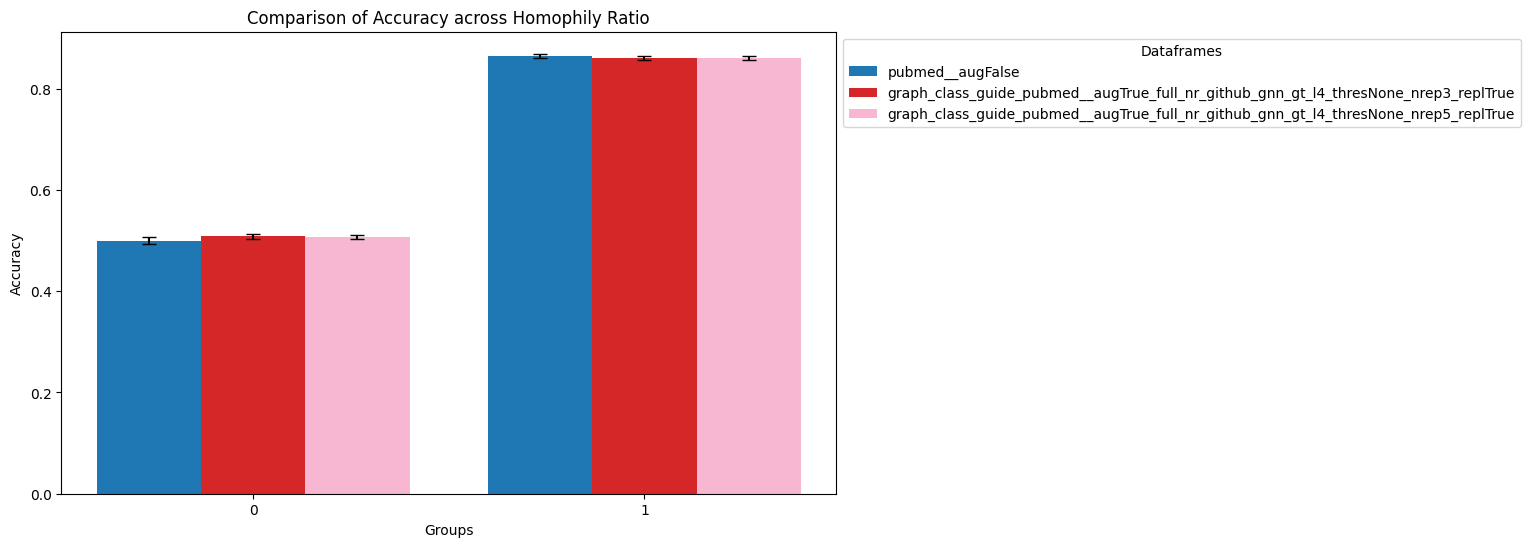

In [41]:
data_name = 'pubmed'
binary = True
quantile = False
num_groups = 5

groups_to_keep = [
    'graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep3_replTrue',
    'graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep5_replTrue'
]
main(data_name, binary, quantile, num_groups, groups_to_keep)

thres: [0, 0.0, 0.5, 0.694799345433712, 0.8571428656578064, 1.0, 1]
Prefix: pubmed__augFalse
sd = 0.2591 +/- 0.0051
cv = 0.3272 +/- 0.0063
Prefix: graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep3_replTrue
sd = 0.2563 +/- 0.0051
cv = 0.3244 +/- 0.0067


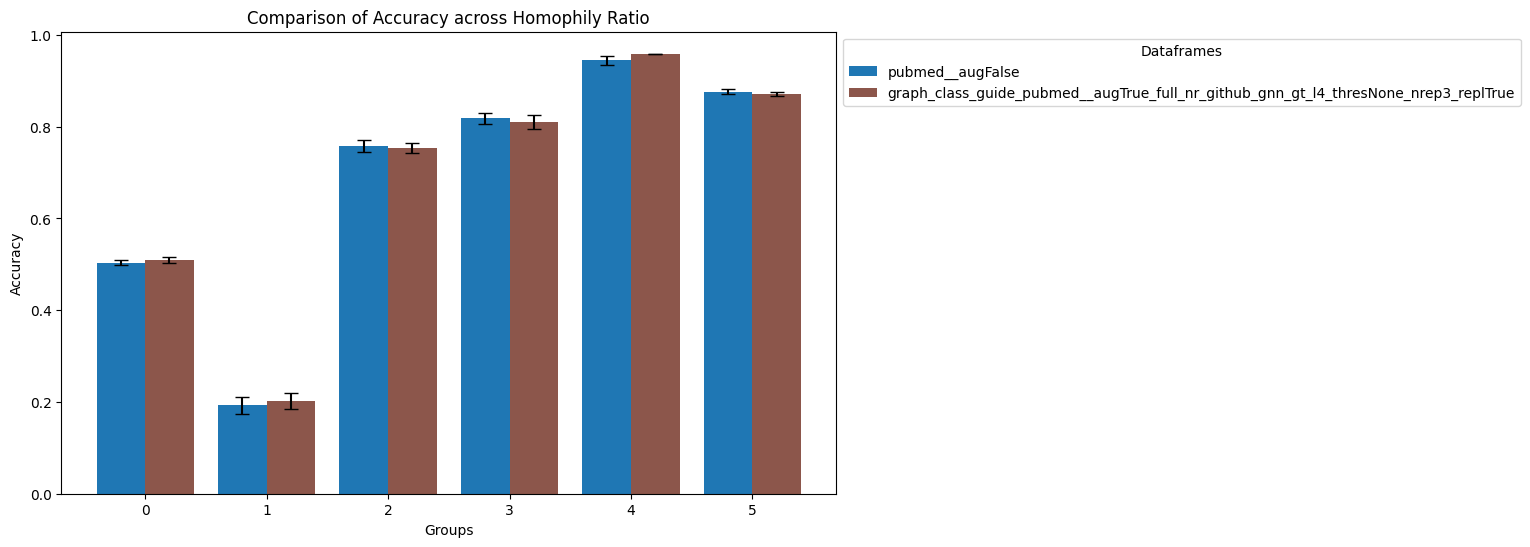

In [49]:
data_name = 'pubmed'
binary = False
quantile = True
num_groups = 6

groups_to_keep = [
    'graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep3_replTrue',
    # 'graph_class_guide_pubmed__augTrue_full_nr_github_gnn_gt_l4_thresNone_nrep5_replTrue'
]
main(data_name, binary, quantile, num_groups, groups_to_keep)